## Analysis of a Buck-Boost Converter

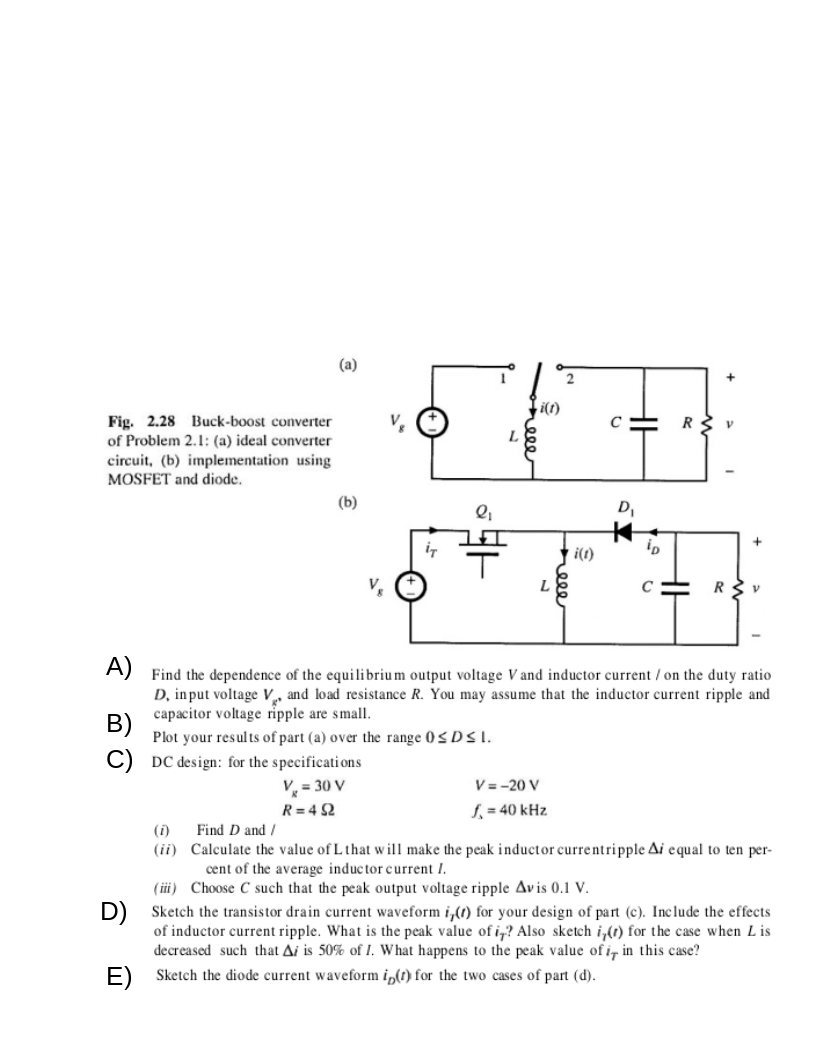

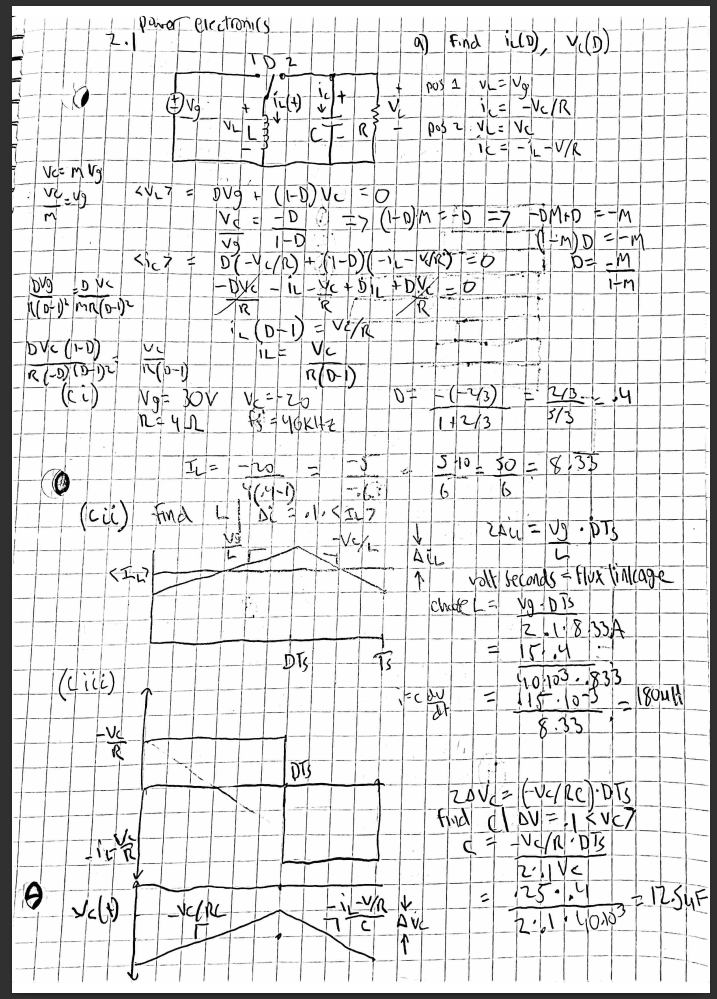

### Import what is needed

In [1]:
from IPython.display import display, Latex
from functools import wraps
from orderedset import OrderedSet
import sympy
from sympy.core.symbol import symbols, Symbol
from sympy.solvers.solveset import nonlinsolve
from sympy import solveset
from sympy import Eq
from sympy.utilities.lambdify import lambdify
from sympy.printing import latex, pprint
from sympy import Symbol, simplify
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, EngFormatter

from math import log10
from PyLTSpice import LTSpice_RawRead
from sympy.solvers import solve
import sys
import logging
from ipywidgets import FloatSlider, interact, interactive
from converter7 import * #works acceptably with converter3

Found Numpy. Will be used for storing data


In [ ]:
logformat = '{asctime}\n{message}'
logger = logging.getLogger(__name__)
if logger.hasHandlers():
    #handlers somehow stay alive even after restarting iPython
    #console and clearing variables
    logger.handlers.clear()

logger.setLevel('DEBUG')
print(logger)
print(__name__)
# Use FileHandler() to log to a file
file_handler = logging.FileHandler('Problem2-1.log', mode='w')
formatter = logging.Formatter(fmt=logformat, style='{' )
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

### Define Symbols

In [2]:
def make_symbols():
    global R, C, L, D, s, Vc, Vg, VL, iin, iL, iC, iR, fs, M, delta_iL, delta_vC, Ts
    
    R = variable('R', 'ohms', None, real=True, positive=True)
    C = variable('C', 'F', None, real=True, positive=True)
    L = variable('L', 'H', real=True, positive=True)
    D = variable('D', '%', real=True, positive=True)
    
    fs = variable('f_s', 'Hz', real=True, positive=True)
    

    Vc = variable('V_c', 'V', real=True)
    Vg = variable('V_g', 'V', real= True)
    VL = variable('V_L', 'V', real= True)

    iin = variable('i_in', 'A', real=True)
    iL = variable('i_L', 'A', real=True)
    iC = variable('i_C', 'A', real=True)
    iR = variable('i_R', 'A', real=True)
    delta_iL = variable('\Delta i_L', 'A', 'delta_iL', real=True)
    delta_vC = variable('\Delta v_C', 'V', 'delta_vC', real=True)
    M = variable('M', real=True)
    
    return
make_symbols()

### Part (a) - finding average inductor current and capacitor voltage as function of D, Vg, R

In [3]:
buckboost = converter()
buckboost.add_equation(D*Vg + (1-D)*Vc - 0) #VLavg must equal 0 in steady state
buckboost.add_equation(M - Vc/Vg)
buckboost.showequations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [4]:
myprint(Vc, *buckboost.solver(given={}, want=Vc))
myprint(M, *buckboost.solver(given={}, want=M))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

A note on polarity - For 0 < D < 1, Vc is always opposite polarity of Vg. 

In [5]:

print(f' Vc computation test1: {buckboost.computesym(Vc, {M:-2, Vg:5})}')
print(f' Vc computation test2: {buckboost.computesym(Vc, {Vg:10, M:3})}')
print(f' Vc computation test3: {buckboost.computesym(Vc, {Vg:10, D:.3})}')
print(f' M computation test1: {buckboost.computesym(M, {Vc:-10, Vg:5})}')
print(f' M computation test2: {buckboost.computesym(M, {D:.4})}')




 Vc computation test1: -10
 Vc computation test2: 30
 Vc computation test3: -4.285714285714286
 M computation test1: -2.0
 M computation test2: -0.6666666666666667


#### Our next equation from hand analysis is capacitor charge balance = 0. From it, we can find average inductor current.

In [6]:
eq2 = D*(-Vc/R)+(1-D)*(-iL-Vc/R) - 0 #iCavg must equal 0 in steady state
buckboost.add_equation(eq2)
eq3 = R - Vc/iR
buckboost.add_equation(eq3)
buckboost.showequations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
ans =buckboost.solver(given={}, want=iL)
myprint(iL, *ans)

<IPython.core.display.Latex object>

The inductor current is positive, from the switch node to ground. The output voltage and load current are negative, with respect to how they were drawn. 

In [8]:
print(f' iL computation test1: {buckboost.computesym(iL, {R:2, Vc:5, D:.9})}')
print(f' iL computation test2: {buckboost.computesym(iL, {D:.2, iR:50})}')

 iL computation test1: -25.000000000000007
 iL computation test2: -62.5


### Part (B) - plotting
- plot output voltage (same as capacitor voltage) as function of D
- plot average inductor current as function of D, for a few different loads.
- Note that iR = Vc/R

In [9]:
%matplotlib notebook

<IPython.core.display.Javascript object>


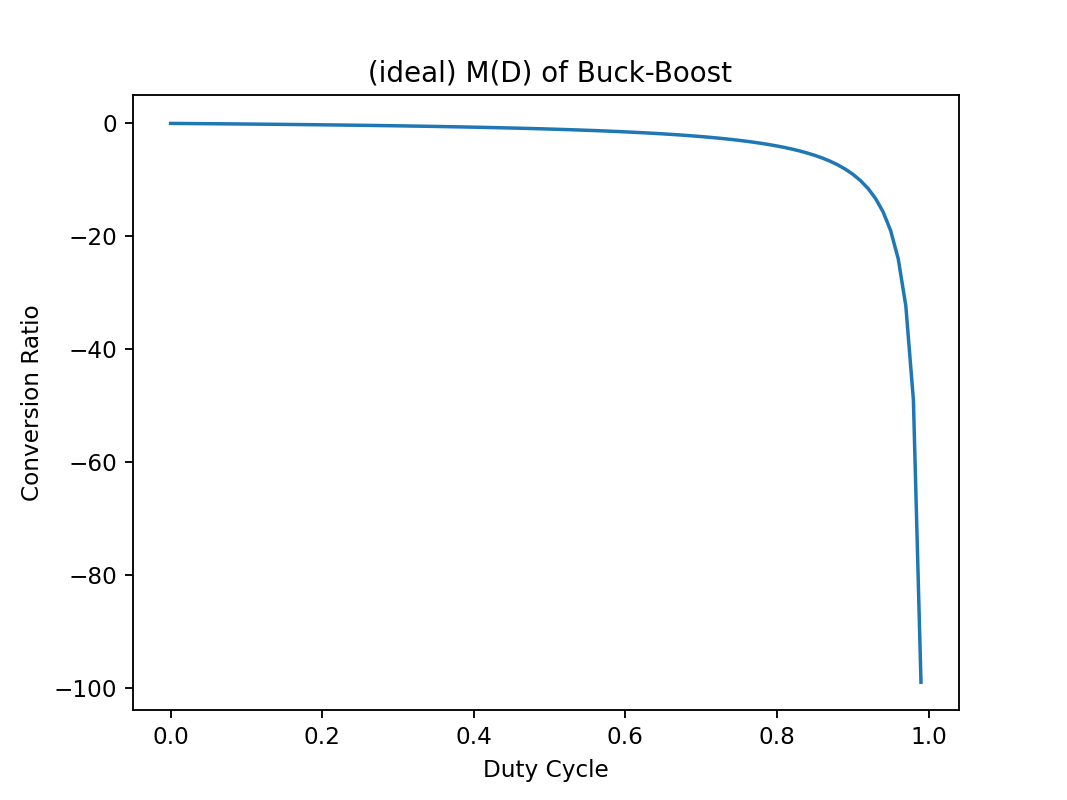

<IPython.core.display.Javascript object>


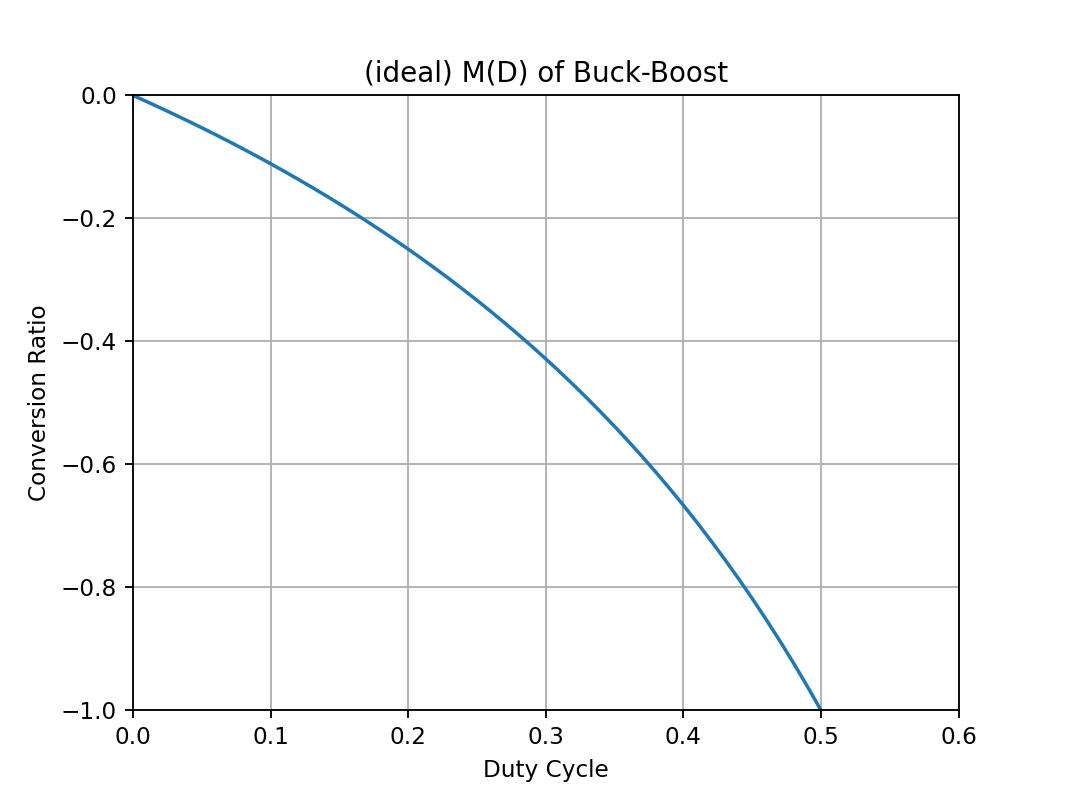

<IPython.core.display.Javascript object>


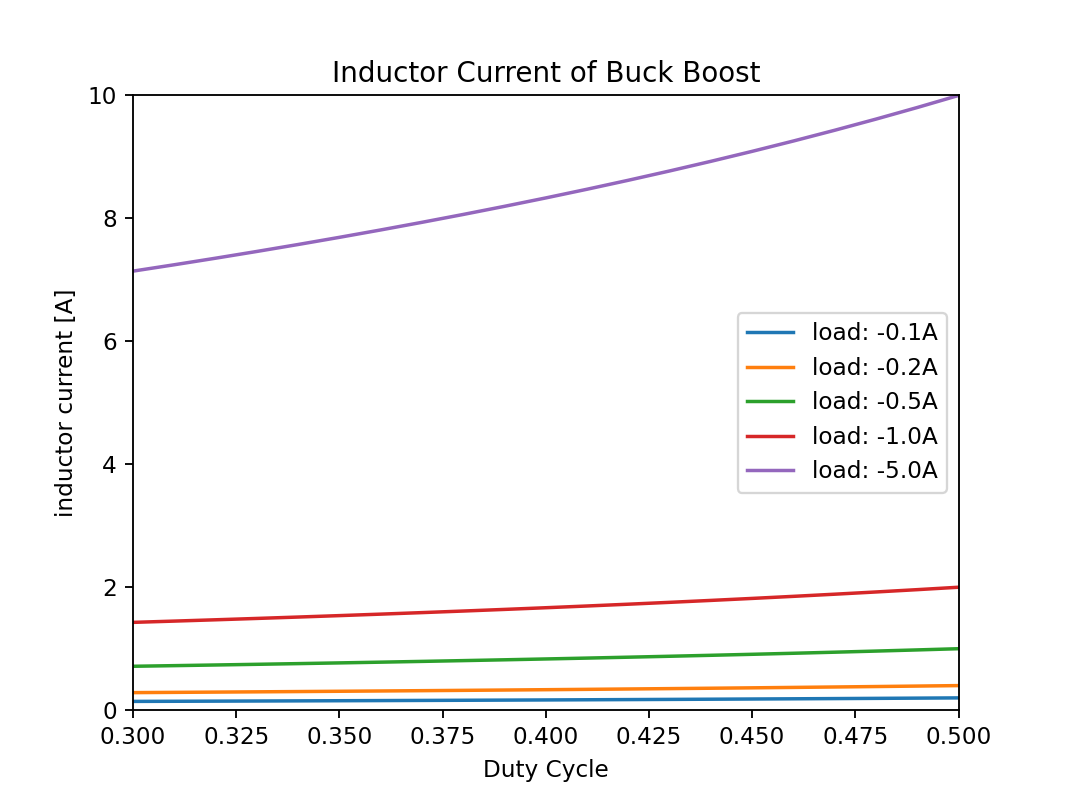

Text(0, 0.5, 'inductor current [A]')

In [10]:
duty = np.linspace(0, .99, 100)
fig, ax = plt.subplots(subplot_kw={'title':' (ideal) M(D) of Buck-Boost'})
M = buckboost.computesym(M, {D:duty})
ax.plot(duty, M)
ax.set_xlabel('Duty Cycle')
ax.set_ylabel('Conversion Ratio')
#plot again, but zoom in 
fig, ax = plt.subplots(subplot_kw={'title':'(ideal) M(D) of Buck-Boost'})
ax.plot(duty, M)
ax.set_xlabel('Duty Cycle')
ax.set_ylabel('Conversion Ratio')
ax.set_ylim(bottom=-1, top=0)
ax.set_xlim(left=0, right=.6)
ax.grid()

load_currents = [-1*el for el in [.1, .2, .5, 1, 5]]
fig, ax = plt.subplots(subplot_kw={'title':'Inductor Current of Buck Boost'})
for i in load_currents:    
    #il = i/(D-1)
    il = buckboost.computesym(iL, {iR :i, D:duty})
    ax.plot(duty, il, label='load: {:.1f}A'.format(i))
ax.legend()
ax.set_xlabel('Duty Cycle')
ax.set_xlim(left=.3, right=.5)
ax.set_ylim(bottom=0, top=10)
ax.set_ylabel('inductor current [A]')


### Part C.i) find D and iL for the given values



Answer: Just use those nice plots! 
M = Vc/Vg = -20/30 = -.66
Duty cycle looks to be about .38, from the plot
Then iL = Vc/(R*(D-1)) = -8A
Alternatively, use a solver from Sympy, see below. 


In [11]:
make_symbols()

In [12]:
given = {Vg:30, R:4, Vc:-20, fs:40e3, M:-20/30}

In [13]:
ans =buckboost.solver(given={}, want=D)
myprint(D, *ans)

<IPython.core.display.Latex object>

In [14]:
buckboost.computesym(D, given)

0.4

In [15]:
ans =buckboost.solver(given={}, want=iL)
myprint(iL, *ans)

<IPython.core.display.Latex object>

In [16]:
buckboost.computesym(iL, given)

8.333333333333334

### Part C.ii) What value of inductance will make the ripple current = 10% of average current?

In [17]:
Ts = 1/fs
buckboost.add_equation(M - Vc/Vg ) #conversion ratio M
buckboost.add_equation(2*delta_iL - Vg*D*Ts/L) #inductor current ripple
buckboost.add_equation(2*delta_vC - (Vc/R)*(1/C)*D*Ts) #capacitor voltage ripple
buckboost.add_equation(delta_iL < .1*iL) #design spec
buckboost.add_equation(delta_vC < .1*Vc) #design spec
buckboost.add_equation(iL - Vc/(R*(D-1))) #average inductor current
buckboost.showequations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

\Delta i_L < 0.1*i_L

\Delta v_C < 0.1*V_c

In [18]:
given = {Vg:30, R:4, Vc:-20, fs:40e3, delta_iL:8.333/10}

In [ ]:
buckboost.equations

In [19]:
ans =buckboost.solver(given={}, want=L)
myprint(L, *ans)

<IPython.core.display.Latex object>

In [20]:
print(buckboost.computesym(L, given))

0.00018000720028801153


In [ ]:
buckboost.relations

In [ ]:
buckboost.recurse

In [ ]:
display(buckboost.get_expression(L, given))

In [ ]:
buckboost.showresult(L, given)

In [ ]:
given

### Part C.iii) What value of capacitance will make the ripple voltage = 10% of average voltage?

In [ ]:
given = {Vg:30, R:4, Vc:-20, fs:40e3, M:-20/30, delta_vC: -20/10}

In [ ]:

ans =buckboost.solver(given=given, want=C)
myprint(C, *ans)
buckboost.computesym(C, given)

### Part D) Plot the transistor drain current for a switching period, dependent on L

The transistor drain current is the inductor current while its on, and zero when its not. It can be represented with 6 points: 
1. (avg - rip, 0)
2. (avg, DTs/2)
3. (avg + rip, DTs)
4. (0, DTs+epsilon) where epsilon is some nonzero fall time
5. (0, Ts)
5. (avg - rip, Ts+epsilon) where epsilon is some nonzero rise time

The expressions for the ripple amounts were included in the equations of parts (Cii) and (Ciii), and are from 
the hand analysis. The inputs are are: Vg, D, R, L, C, Ts. but we want to see the effect of only the inductance value L on current ripple. Solve for current ripple with the other inputs given. 


In [21]:

ans =buckboost.solver(given=given, want=delta_iL)
myprint(delta_iL, *ans)

<IPython.core.display.Latex object>

In [22]:
buckboost.computesym(delta_iL, given={L:50e-6})

In [23]:
rip = lambda l: buckboost.computesym(delta_iL, given = {L:l})
print(f'example ripple calculation:')
myprint(delta_iL, rip(40e-6))
avg = 8.3 #hard coded because we obtained this result earlier
duty = .4 #hard coded because we obtained this result earlier
period = 1/given[fs]
epsilon = 1e-5*period


t = np.array([0, duty*period/2, duty*period,duty*period+epsilon, period, period+epsilon])
def transistor_current(l):
    r = rip(l)
    return np.array([avg- r, avg, avg+r, 0, 0, avg-r])
#transistor current = 

example ripple calculation:


<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


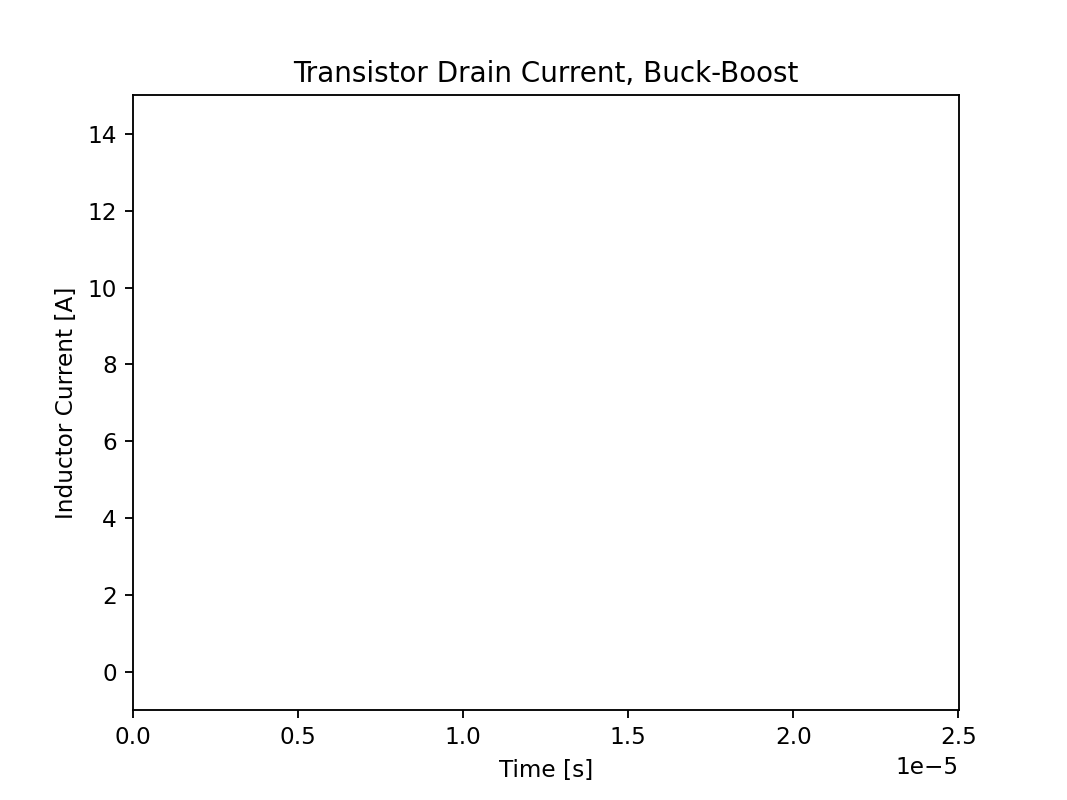

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [24]:
%matplotlib notebook 
#doesn't work with inline backend
max_inductance = 200e-6
min_inductance = 30e-6
l_widget = FloatSlider(min=min_inductance, max=max_inductance, step=10e-6, readout_format='.2e')


fig, ax = plt.subplots(subplot_kw={'title':'Transistor Drain Current, Buck-Boost'})
ax.set_ylim(bottom= -1, top=15)
ax.set_xlim(left=0, right=t[-1]+epsilon)
ax.set_ylabel('Inductor Current [A]')
ax.set_xlabel('Time [s]')
l, = ax.plot(t, transistor_current(180e-6))
def g(inductance):
    
    l.set_ydata(transistor_current(inductance))
    fig.canvas.draw()

interactive_plot = interactive(g, inductance = l_widget)
interactive_plot

### Part E) Plot diode current\
The diode current is the inductor current during the off time of the transistor. 

In [25]:
t = np.array([0, duty*period, duty*period+epsilon,duty*period+(1-duty)*period/2, period, period+epsilon])
def diode_current(l):
    r = rip(l)
    return np.array([0, 0, avg+r, avg, avg-r,0])

<IPython.core.display.Javascript object>


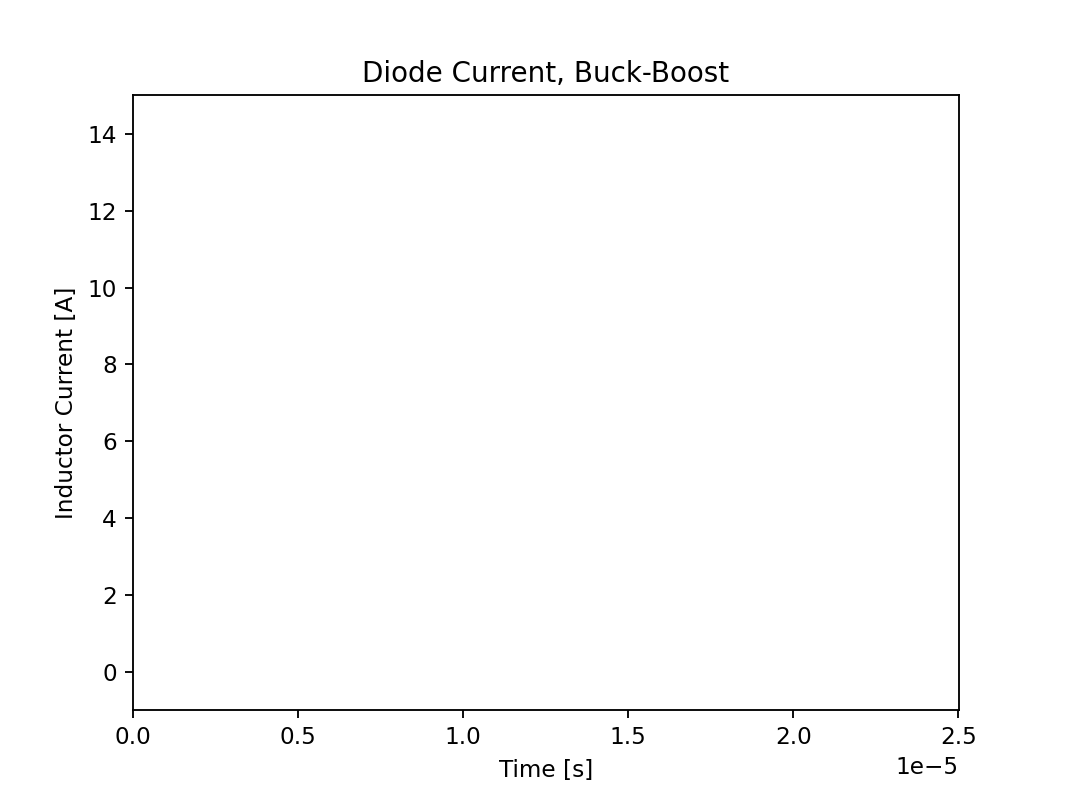

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [26]:
l_widget = FloatSlider(min=min_inductance, max=max_inductance, step=10e-6, readout_format='.2e')


fig, ax = plt.subplots(subplot_kw={'title':'Diode Current, Buck-Boost'})
ax.set_ylim(bottom= -1, top=15)
ax.set_xlim(left=0, right=t[-1]+epsilon)
ax.set_ylabel('Inductor Current [A]')
ax.set_xlabel('Time [s]')
l, = ax.plot(t, diode_current(180e-6))
def h(inductance):
    
    l.set_ydata(diode_current(inductance))
    fig.canvas.draw()

interactive_plot = interactive(h, inductance = l_widget)
interactive_plot

#### Lastly, the results can be compared to a spice simulation, with the nominal 180uH:

In [ ]:
raw = os.path.join(os.getcwd(), 'problem2-1.raw')
LTR = LTSpice_RawRead.LTSpiceRawRead(raw) 
Vc = LTR.get_trace("V(vc)").get_wave()
iT = LTR.get_trace("I(S1)").get_wave()
iL = LTR.get_trace("I(L1)").get_wave()
t_sim = LTR.get_trace('time').get_time_axis()

In [ ]:
%matplotlib inline
subplot_kw={'title':'Spice Simulation, Buck-Boost',
           'xlabel': 'Time [s]'}
      
#fig, (ax1, ax2) = plt.subplots(2,1)
fig, ax1 = plt.subplots(subplot_kw = subplot_kw)
ax1.set_xlim(left = 240e-6, right=240e-6+4*period)
major_formatter= EngFormatter(unit='s', places=0, sep='')
ax1.xaxis.set_major_formatter(major_formatter)

color = 'tab:red'
ax2 = ax1.twinx()
ax1.plot(t_sim, Vc, label='Vout', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Output Capacitor Voltage [V]', color=color)

color = 'tab:blue'
ax2.plot(t_sim, iL, label='iL', color=color)
ax2.set_ylim(0, 12)
ax2.set_ylabel('Inductor Current [A]', color=color)
ax2.tick_params(axis='y', labelcolor=color)


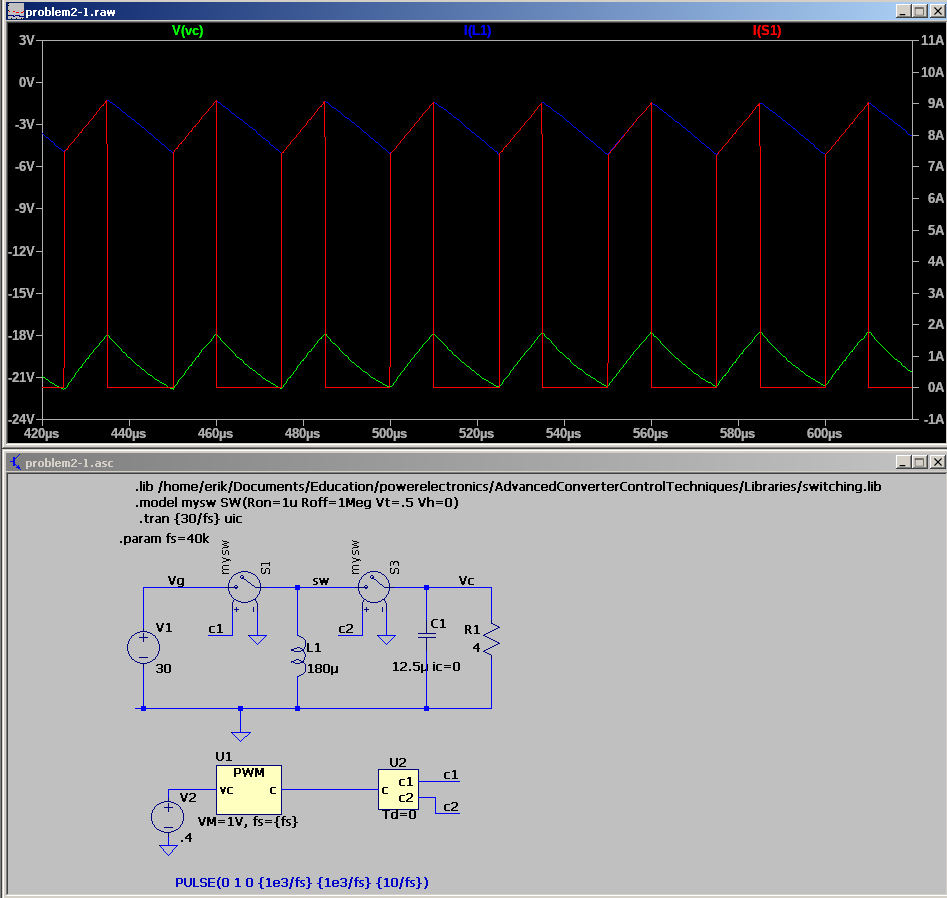